In [14]:
import numpy as np 
import scipy
import matplotlib.pyplot as plt

import torch 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns 
import pandas as pd 
from mutedpy.experiments.streptavidin.streptavidin_loader import *
from sklearn.metrics import r2_score
from mutedpy.experiments.streptavidin.streptavidin_loader import tobias_colors
from mutedpy.utils.sequences.sequence_utils import ProteinOperator

In [15]:
# load model 
from mutedpy.experiments.streptavidin.active_learning.compare_different_models import load_model
from mutedpy.utils.protein_operator import ProteinOperator
Op = ProteinOperator()
model_params = "../../../mutedpy/experiments/streptavidin/active_learning/AA_model/params/final_model_params.p"
GP, embed, paramns = load_model(model_params, "second round fit", vintage = True, model_params_return = True)
#GP.feature_loader.feature_loaders[0].stacking = False


dict_keys(['feature_mask', 'feature_names', 'kernel', 'kernel_object', 'ard_gamma', 'noise_std', 'x', 'y'])
Fitting second round fit
{'kappa': 3.0, 'group': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'ard_gamma': tensor([ 7.8137e+00,  5.4358e+00,  2.8166e+00,  2.8939e+00,  4.1474e+01,
         3.6573e+00,  9.8912e+00,  4.7051e+00,  5.3773e+00, -6.5864e+00,
         1.4200e+01,  2.0355e+00, -4.3900e+04,  5.0735e+00,  5.8495e-01,
         7.0307e+00,  1.2471e+01, -2.6259e+00,  4.2812e+00,  5.3976e+00],
       dtype=torch.float64), 'nu': 2.5}
Amino-acids embedding loaded.


In [16]:
paramns

{'feature_mask': tensor([ 33, 115, 119,  37,  50,  70,  90,  41, 113,  64, 126,  12,  31,  43,
          24,  51, 109,  91,  58,  45]),
 'feature_names': array(['VHSE_7_site_1', 'Z_scales3_site_4', 'PC_scores0_site_4',
        'Z_scales3_site_1', 'PC_scores9_site_1', 'PC_scores3_site_2',
        'Z_scales4_site_3', 'PC_scores0_site_1', 'Z_scales1_site_4',
        'Z_scales4_site_2', 'PC_scores7_site_4', 'Z_scales4_site_0',
        'VHSE_5_site_1', 'PC_scores2_site_1', 'PC_scores9_site_0',
        'PC_scores10_site_1', 'VHSE_5_site_4', 'Barley_0_site_3',
        'VHSE_6_site_2', 'PC_scores4_site_1'], dtype='<U18'),
 'kernel': 'ard_matern',
 'kernel_object': <stpy.kernels.KernelFunction at 0x7f8cbc2c5580>,
 'ard_gamma': tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100], dtype=torch.float64),
 'noise_std': tensor(0.1457, dtype=torch.float64),
 'x': tensor

In [17]:
sorted, importance = torch.sort(GP.kernel_object.params['ard_gamma']**2)

In [18]:
site_nums = ['111','112','118','119','121']
for i,index in enumerate(importance):
    c,type,_,loc = paramns['feature_names'][index].split("_")
    print (sorted[i],c, type[-1],site_nums[int(loc)] )

tensor(0.3422, dtype=torch.float64) PC 9 111
tensor(4.1432, dtype=torch.float64) Z 4 111
tensor(6.8952, dtype=torch.float64) Barley 0 119
tensor(7.9331, dtype=torch.float64) PC 0 121
tensor(8.3745, dtype=torch.float64) Z 3 112
tensor(13.3758, dtype=torch.float64) PC 3 118
tensor(18.3291, dtype=torch.float64) VHSE 6 118
tensor(22.1383, dtype=torch.float64) PC 0 112
tensor(25.7406, dtype=torch.float64) PC 2 112
tensor(28.9156, dtype=torch.float64) Z 1 121
tensor(29.1344, dtype=torch.float64) PC 4 112
tensor(29.5474, dtype=torch.float64) Z 3 121
tensor(43.3803, dtype=torch.float64) Z 4 118
tensor(49.4303, dtype=torch.float64) PC 0 112
tensor(61.0542, dtype=torch.float64) VHSE 7 112
tensor(97.8367, dtype=torch.float64) Z 4 119
tensor(155.5285, dtype=torch.float64) VHSE 5 121
tensor(201.6307, dtype=torch.float64) PC 7 121
tensor(1720.0651, dtype=torch.float64) PC 9 112
tensor(1.9272e+09, dtype=torch.float64) VHSE 5 112


In [19]:
# Let us plot these features w.r.t. fitness on the dataset

In [20]:
x_all,y_all,dts = load_everything_we_have()

In [21]:
topk = 5

In [22]:
selected_features = embed(x_all)[:,importance[0:topk]]
selected_features = torch.hstack((selected_features, y_all,(y_all > 1.).double()))
#selected_features = torch.hstack((selected_features, torch.from_numpy(dts['site0T'].values).view(-1,1) ))

In [23]:
selected_features.size()

torch.Size([4418, 7])

In [24]:
P = ProteinOperator()

In [25]:

#plt.savefig('pair_plot.pdf',dpi = 300)

In [27]:
x_n,y_n,dts = load_first_round()

In [28]:
dictionary = {}
plt.figure()
j = 0
#print ("site:",j)
def shift(lst, shift_amount):
    return lst[-shift_amount % len(lst):] + lst[:-shift_amount % len(lst)]
dictionary[str(j)] = {}
vals1 = []
vals2 = []
for i in range(20):
    x_point = shift([i,0,0,0,0],j)
    phi = embed(torch.Tensor([x_point]))
    dictionary[str(j)][str(i)] = phi
    vals1.append(float(phi.view(-1)[importance[0]]))
    vals2.append(float(phi.view(-1)[importance[1]]))

<Figure size 640x480 with 0 Axes>

In [29]:
dictionary = {}
plt.figure()
j = 3
dictionary[str(j)] = {}
vals3 = []
for i in range(20):
    x_point = shift([i,0,0,0,0],j)
    phi = embed(torch.Tensor([x_point]))
    dictionary[str(j)][str(i)] = phi
    vals3.append(float(phi.view(-1)[importance[2]]))


<Figure size 640x480 with 0 Axes>

In [30]:
dictionary = {}
plt.figure()
j = 4
dictionary[str(j)] = {}
vals4 = []
for i in range(20):
    x_point = shift([i,0,0,0,0],j)
    phi = embed(torch.Tensor([x_point]))
    dictionary[str(j)][str(i)] = phi
    vals4.append(float(phi.view(-1)[importance[3]]))


<Figure size 640x480 with 0 Axes>

In [31]:
dictionary = {}
plt.figure()
j = 1
dictionary[str(j)] = {}
vals5 = []
for i in range(20):
    x_point = shift([i,0,0,0,0],j)
    phi = embed(torch.Tensor([x_point]))
    dictionary[str(j)][str(i)] = phi
    vals5.append(float(phi.view(-1)[importance[4]]))


<Figure size 640x480 with 0 Axes>

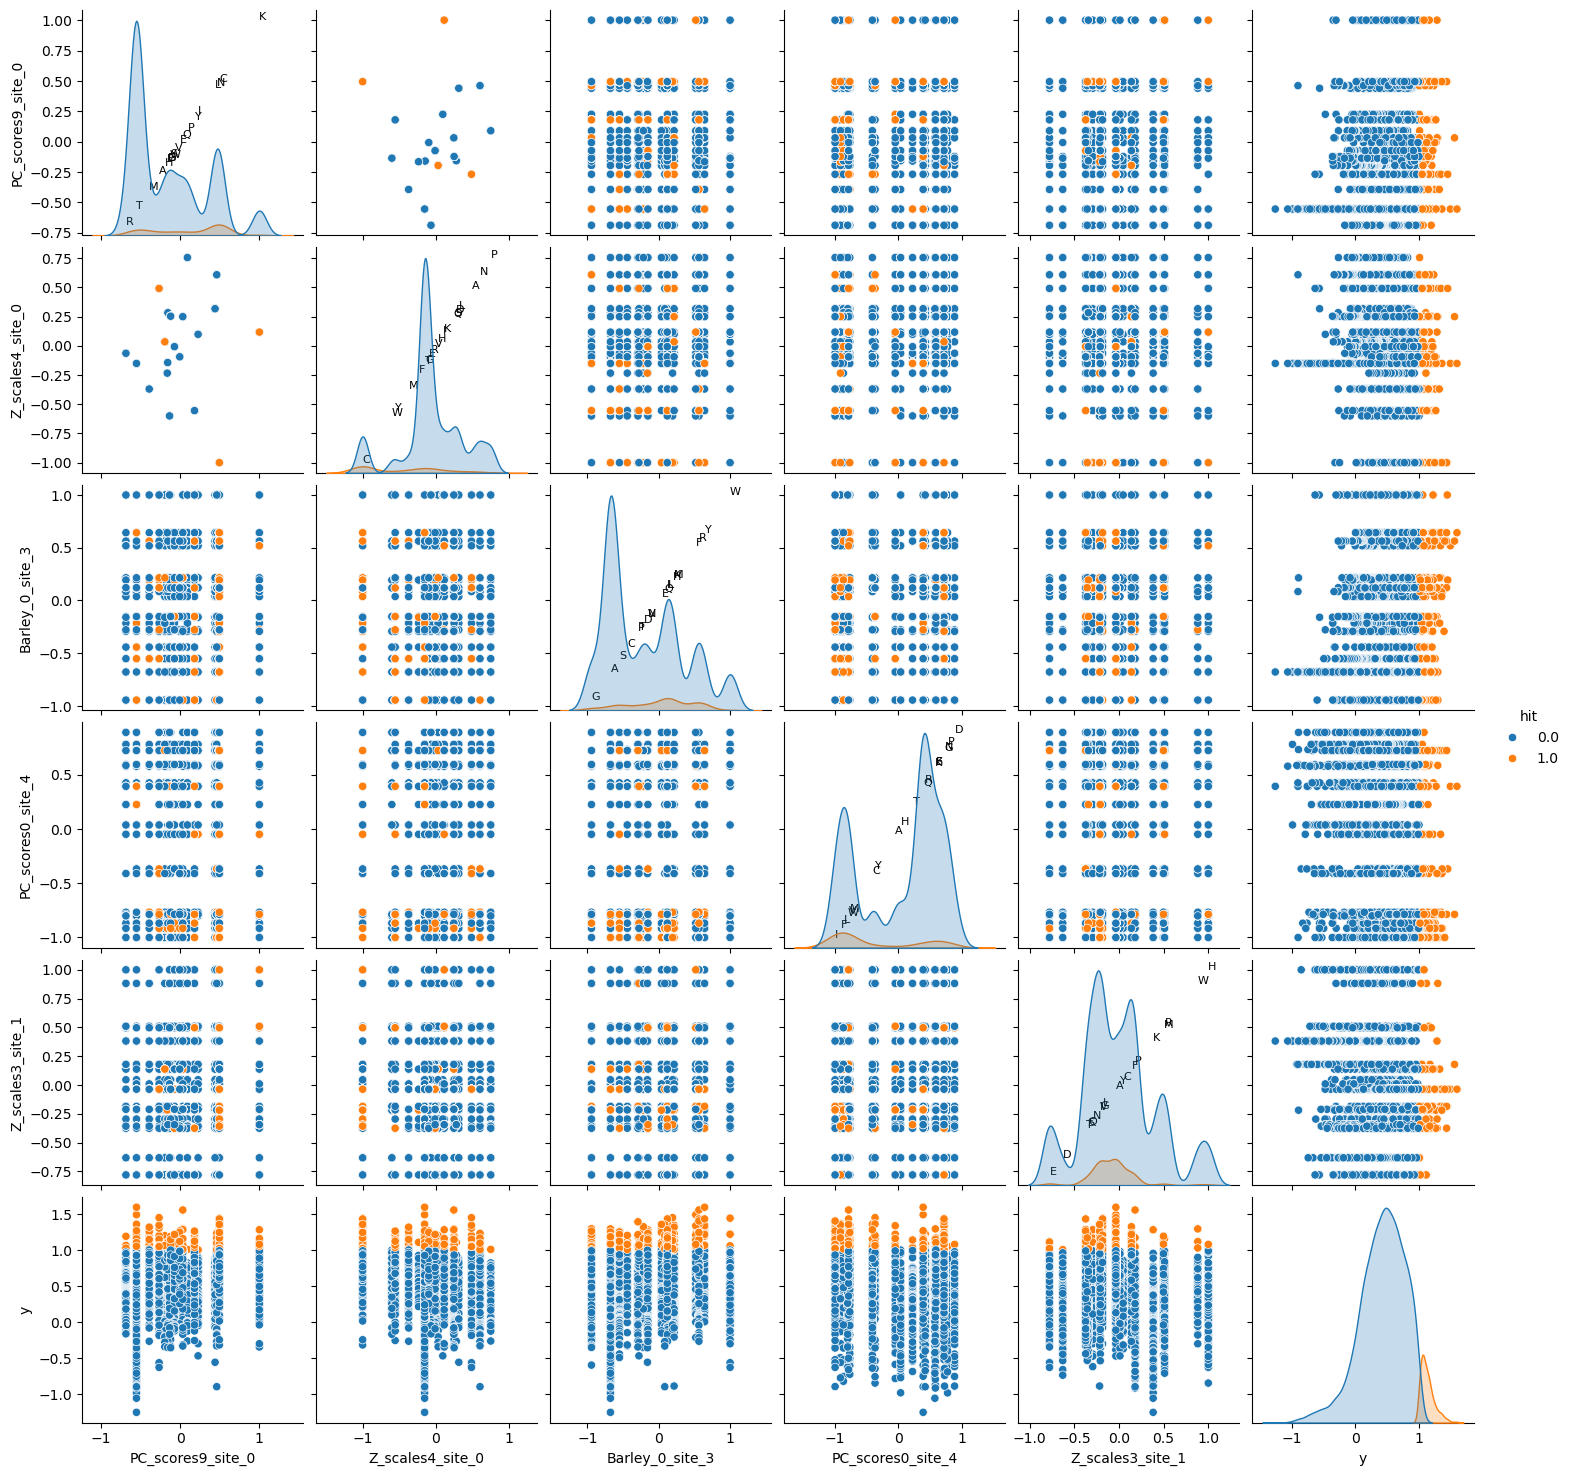

In [33]:
import seaborn as sns
df = pd.DataFrame(data=selected_features, columns = list(paramns['feature_names'][importance[0:topk]])+['y','hit'])
pair_plot = sns.pairplot(df, hue = 'hit')

ax = pair_plot.axes[0, 0]
#ax.scatter(np.array(vals1), np.array(vals1)*0+0.)
for i, v in enumerate(vals1):
    ax.annotate(P.inv_dictionary[i], (v,v*0+v),xytext=(v, v*0+v), fontsize = 8)

ax = pair_plot.axes[1, 1]
#ax.scatter(np.array(vals2), np.array(vals2)*0+0.)
for i, v in enumerate(vals2):
    ax.annotate(P.inv_dictionary[i], (v,v*0+v),xytext=(v, v*0+v), fontsize = 8)

ax = pair_plot.axes[2, 2]
#ax.scatter(np.array(vals2), np.array(vals2)*0+0.)
for i, v in enumerate(vals3):
    ax.annotate(P.inv_dictionary[i], (v,v*0+v),xytext=(v, v*0+v), fontsize = 8)
    
ax = pair_plot.axes[3, 3]
#ax.scatter(np.array(vals2), np.array(vals2)*0+0.)
for i, v in enumerate(vals4):
    ax.annotate(P.inv_dictionary[i], (v,v*0+v),xytext=(v, v*0+v), fontsize = 8)
    
ax = pair_plot.axes[4, 4]
#ax.scatter(np.array(vals2), np.array(vals2)*0+0.)
for i, v in enumerate(vals5):
    ax.annotate(P.inv_dictionary[i], (v,v*0+v),xytext=(v, v*0+v), fontsize = 8)
    
    
    
plt.savefig('pair_plot.pdf',dpi = 300)
plt.show()

In [32]:
plt.show()

In [53]:
iris = sns.load_dataset("iris")
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [55]:
df = pd.melt(iris, iris.columns[-1], iris.columns[:-1])
df

,species,variable,value
0,setosa,sepal_length,5.1
1,setosa,sepal_length,4.9
2,setosa,sepal_length,4.7
3,setosa,sepal_length,4.6
4,setosa,sepal_length,5.0
...,...,...,...
595,virginica,petal_width,2.3
596,virginica,petal_width,1.9
597,virginica,petal_width,2.0
598,virginica,petal_width,2.3


In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#iris = sns.load_dataset("iris")
df = pd.DataFrame(data=selected_features, columns = list(paramns['feature_names'][importance[0:topk]])+['y','hit'])
d = pd.melt(df,  list(paramns['feature_names'][importance[0:topk]]),'f')
df.head(2)

,PC_scores9_site_0,Z_scales4_site_0,Barley_0_site_3,PC_scores0_site_4,Z_scales3_site_1,y,hit
0,-0.554437,-0.150302,0.518692,0.393072,-0.036030,1.488662,1.0
1,0.031466,0.250000,-0.677570,0.586153,0.882036,1.291941,1.0


Text(0.5, 0, 'Fitness')

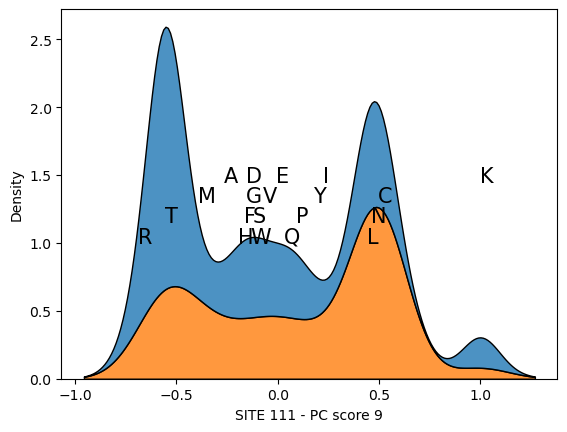

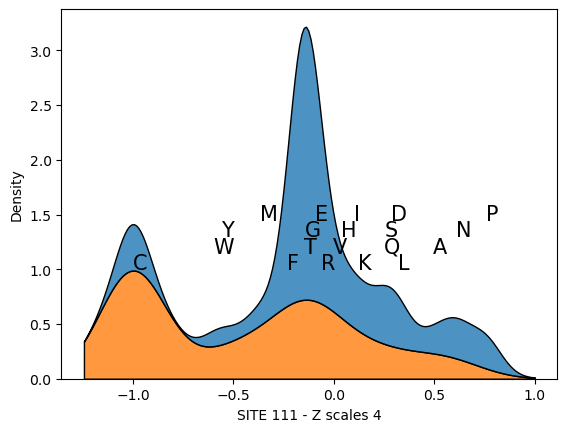

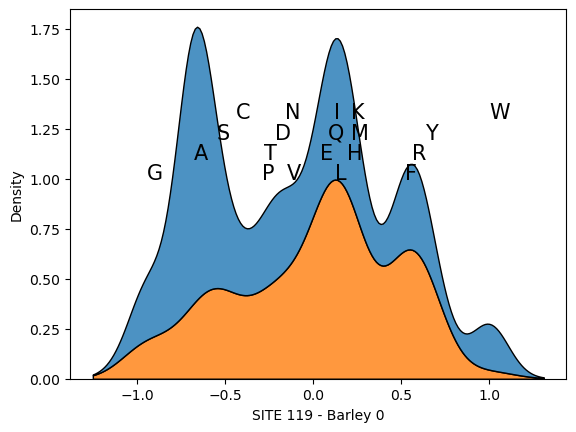

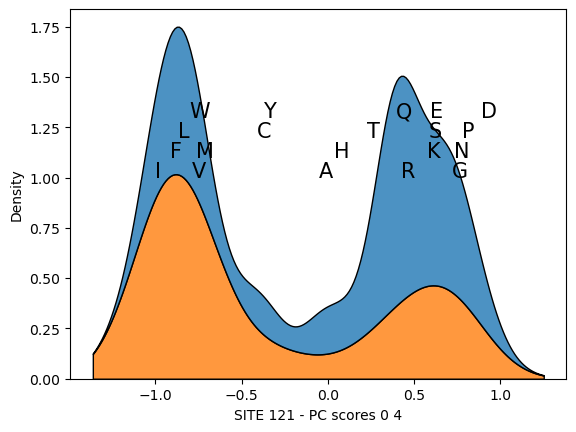

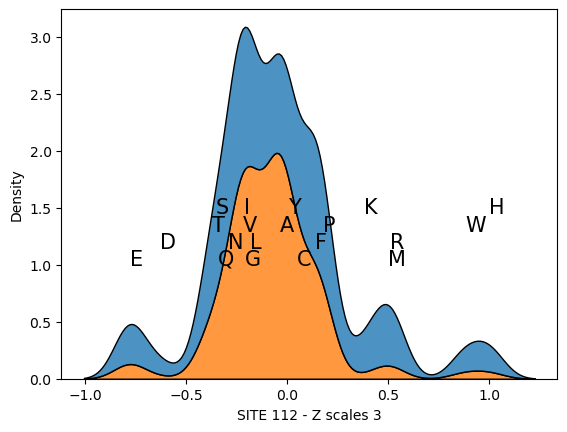

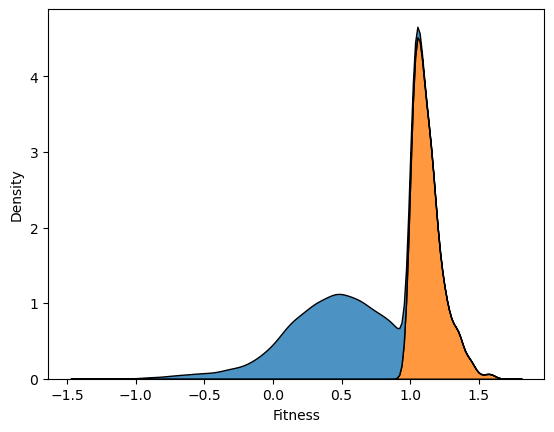

In [121]:
#g = sns.FacetGrid(d, col = "PC_scores9_site_0",hue="variable", col_wrap=3)
# g.map(sns.kdeplot, "PC_scores9_site_0")
#g = sns.FacetGrid(col_wrap = 3)
#g = sns.FacetGrid(data=df,col_wrap=3)
ax = sns.kdeplot(data=df, x="PC_scores9_site_0", hue="hit", multiple="stack", legend = False,alpha=.8,common_norm=False)
plt.xlabel("SITE 111 - PC score 9")

args_sort = np.argsort(vals1)
for i, v in enumerate(np.array(vals1)[args_sort]):
    ax.annotate(P.inv_dictionary[args_sort[i]], (v,1.+0.15*(i%4)),xytext=(v, 1.+0.15*(i%4)), fontsize = 15)

plt.figure()
ax = sns.kdeplot(data=df, x="Z_scales4_site_0", hue="hit", multiple="stack", legend = False,alpha=.8,common_norm=False)
plt.xlabel("SITE 111 - Z scales 4")

args_sort = np.argsort(vals2)
for i, v in enumerate(np.array(vals2)[args_sort]):
    ax.annotate(P.inv_dictionary[args_sort[i]], (v,1.+0.15*(i%4)),xytext=(v, 1.+0.15*(i%4)), fontsize = 15)


plt.figure()
ax = sns.kdeplot(data=df, x="Barley_0_site_3", hue="hit", multiple="stack", legend = False,alpha=.8,common_norm=False)
plt.xlabel("SITE 119 - Barley 0")

args_sort = np.argsort(vals3)
for i, v in enumerate(np.array(vals3)[args_sort]):
    ax.annotate(P.inv_dictionary[args_sort[i]], (v,1.+0.1*(i%4)),xytext=(v, 1.+0.1*(i%4)), fontsize = 15)


plt.figure()
ax = sns.kdeplot(data=df, x="PC_scores0_site_4", hue="hit", multiple="stack", legend = False,alpha=.8,common_norm=False)
plt.xlabel("SITE 121 - PC scores 0 4")

args_sort = np.argsort(vals4)
for i, v in enumerate(np.array(vals4)[args_sort]):
    ax.annotate(P.inv_dictionary[args_sort[i]], (v,1.+0.1*(i%4)),xytext=(v, 1.+0.1*(i%4)), fontsize = 15)


plt.figure()
ax = sns.kdeplot(data=df, x="Z_scales3_site_1", hue="hit", multiple="stack", legend = False,alpha=.8,common_norm=False)
plt.xlabel("SITE 112 - Z scales 3")

args_sort = np.argsort(vals5)
for i, v in enumerate(np.array(vals5)[args_sort]):
    ax.annotate(P.inv_dictionary[args_sort[i]], (v,1.+0.15*(i%4)),xytext=(v, 1.+0.15*(i%4)), fontsize = 15)

plt.figure()
ax = sns.kdeplot(data=df, x="y", hue="hit", multiple="stack", legend = False,alpha=.8,common_norm=False)
plt.xlabel("Fitness")

#sns.kdeplot(data=df, x="Z_scales3_site_1", hue="hit", multiple="value", legend = False)
#plt.xlabel("SITE 112 - Z scales 3")
# plt.show()

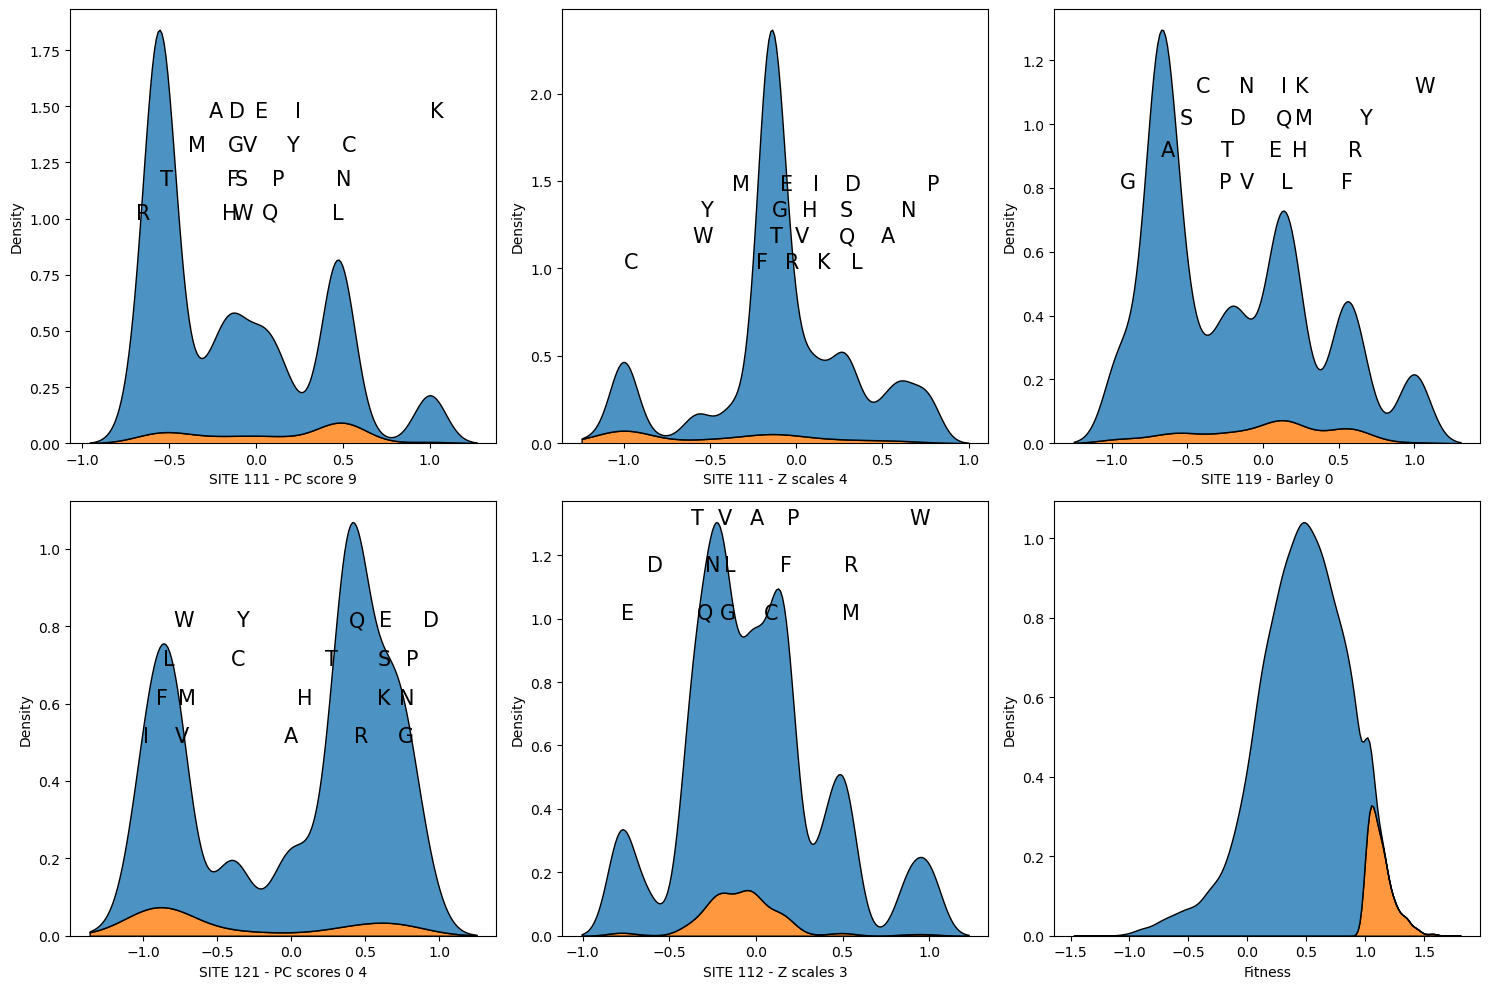

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df, vals1, vals2, vals3, vals4, vals5, and P are already defined

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Plot 1
sns.kdeplot(data=df, x="PC_scores9_site_0", hue="hit", multiple="stack", legend=False, alpha=.8, common_norm=True, ax=axes[0, 0])
axes[0, 0].set_xlabel("SITE 111 - PC score 9")
# Annotations for Plot 1
args_sort = np.argsort(vals1)
for i, v in enumerate(np.array(vals1)[args_sort]):
    axes[0, 0].annotate(P.inv_dictionary[args_sort[i]], (v, 1. + 0.15 * (i % 4)), xytext=(v, 1. + 0.15 * (i % 4)), fontsize=15)

# Plot 2
sns.kdeplot(data=df, x="Z_scales4_site_0", hue="hit", multiple="stack", legend=False, alpha=.8, common_norm=True, ax=axes[0, 1])
axes[0, 1].set_xlabel("SITE 111 - Z scales 4")
# Annotations for Plot 2
args_sort = np.argsort(vals2)
for i, v in enumerate(np.array(vals2)[args_sort]):
    axes[0, 1].annotate(P.inv_dictionary[args_sort[i]], (v, 1. + 0.15 * (i % 4)), xytext=(v, 1. + 0.15 * (i % 4)), fontsize=15)

# Plot 3
sns.kdeplot(data=df, x="Barley_0_site_3", hue="hit", multiple="stack", legend=False, alpha=.8, common_norm=True, ax=axes[0, 2])
axes[0, 2].set_xlabel("SITE 119 - Barley 0")
# Annotations for Plot 3
args_sort = np.argsort(vals3)
for i, v in enumerate(np.array(vals3)[args_sort]):
    axes[0, 2].annotate(P.inv_dictionary[args_sort[i]], (v, 0.8 + 0.1 * (i % 4)), xytext=(v, 0.8 + 0.1 * (i % 4)), fontsize=15)

# Plot 4
sns.kdeplot(data=df, x="PC_scores0_site_4", hue="hit", multiple="stack", legend=False, alpha=.8, common_norm=True, ax=axes[1, 0])
axes[1, 0].set_xlabel("SITE 121 - PC scores 0 4")
# Annotations for Plot 4
args_sort = np.argsort(vals4)
for i, v in enumerate(np.array(vals4)[args_sort]):
    axes[1, 0].annotate(P.inv_dictionary[args_sort[i]], (v, 0.5 + 0.1 * (i % 4)), xytext=(v, 0.5 + 0.1 * (i % 4)), fontsize=15)

# Plot 5
sns.kdeplot(data=df, x="Z_scales3_site_1", hue="hit", multiple="stack", legend=False, alpha=.8, common_norm=True, ax=axes[1, 1])
axes[1, 1].set_xlabel("SITE 112 - Z scales 3")
# Annotations for Plot 5
args_sort = np.argsort(vals5)
for i, v in enumerate(np.array(vals5)[args_sort]):
    axes[1, 1].annotate(P.inv_dictionary[args_sort[i]], (v, 1. + 0.15 * (i % 4)), xytext=(v, 1. + 0.15 * (i % 4)), fontsize=15)

# Plot 6
sns.kdeplot(data=df, x="y", hue="hit", multiple="stack", legend=False, alpha=.8, common_norm=True, ax=axes[1, 2])
axes[1, 2].set_xlabel("Fitness")

plt.tight_layout()  # Adjust the layout
#plt.show()
plt.savefig("pair_plot2.pdf")